## Definicja problemu plecakowego
* 16 przedmiotów
* pojemność plecaka = 3
* wartość przedmiotu losowana z predziału <0,1>
* waga przedmiotu losowana z przedziału <0,1>

In [1]:
%matplotlib inline
import random
import numpy as np
np.random.seed(seed=1337)
max_weight = 3
n_items = 16
max_value = (2**n_items) 
weights =  np.random.rand(n_items)
values = np.random.rand(n_items)
items_size_threshold = 0.5

### Zapis rozwiązania
Dla liczby 10 rozwiązanie wynosi:

[False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True, False]
       
Co oznacza, że brany jest przedmiot drugi i czwarty.

In [2]:
from numba import njit,prange
@njit()
def encodeNumber(number,bits=n_items):
    return np.array([bool(number & (1<<(bits-1-x))) for x in prange(bits)])

## Funkcja oceny rozwiązania 
* zwaraca wartość zabranych przedmiotów
* jeśli waga zabranych przedmiotów jest większa niż maksymalna to zwraca -1

In [3]:
@njit()
def scoreFunction(mask, weights=weights,values=values,max_weight=max_weight,max_value=max_value):
    final_weight = 0
    score = 0 
    for i in prange(weights.size):
        if mask[i]:
            final_weight+=weights[i]
            score+=values[i]
    return -1 if final_weight > max_weight else score

In [4]:
@njit(parallel=True)
def getData():
    return np.array([scoreFunction(encodeNumber(x)) for x in prange(2**n_items)])
%time data = getData()

CPU times: user 1.51 s, sys: 5.96 ms, total: 1.52 s
Wall time: 1.52 s


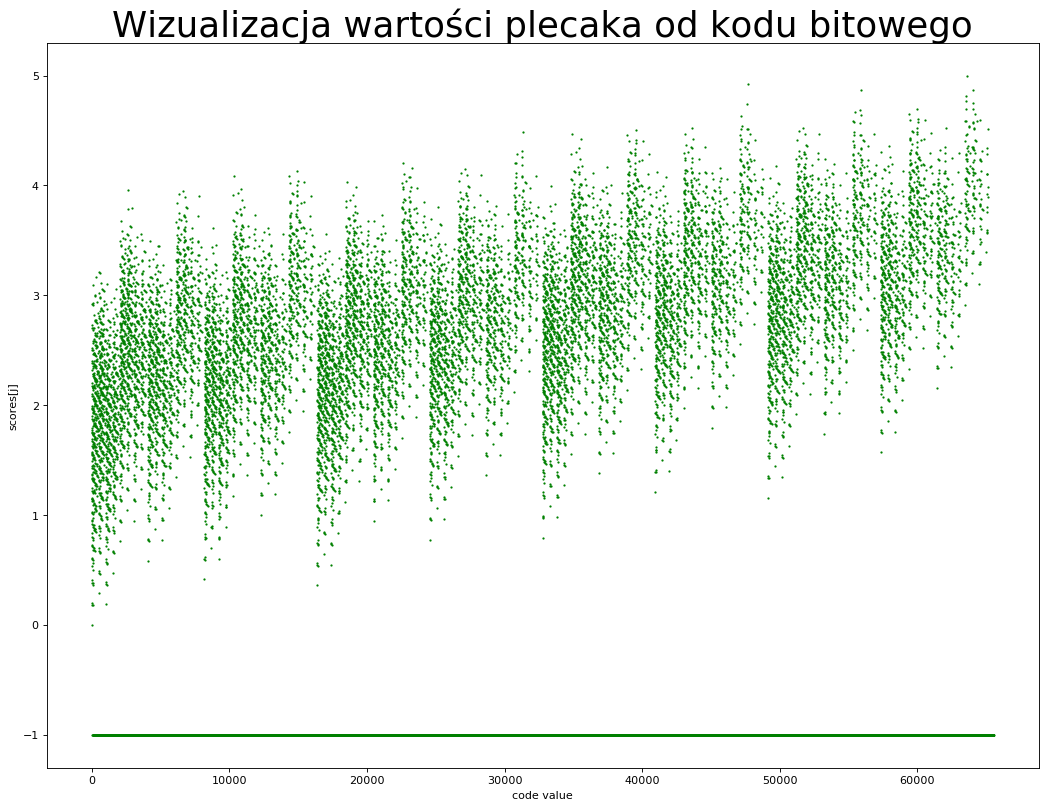

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12), dpi=80) 
plt.title('Wizualizacja wartości plecaka od kodu bitowego', fontsize=32)
plt.scatter(range(len(data)), data,color="g",s=1)
plt.ylabel('scores[j]')
plt.xlabel('code value')
plt.show()

## Wizualizacja grafu sąsiedztwa dla odległości Hamminga

In [6]:
encoded = np.array([encodeNumber(x) for x in prange(2**n_items)])

In [7]:
from sklearn.neighbors import kneighbors_graph
%time encoded_graph = kneighbors_graph(encoded, 1, mode='connectivity', include_self=True, metric ="hamming")

CPU times: user 199 ms, sys: 3.96 ms, total: 203 ms
Wall time: 203 ms


In [8]:
import matplotlib.pyplot as plt
import networkx as nx
encoded_graph_networkx = nx.from_scipy_sparse_matrix(encoded_graph)  

In [9]:
from numba import vectorize, float64
from numba.types import Array
@vectorize([float64(float64)])
def getSizes(score):
    return score*10 +15
@njit()
def getColor(score): # return vector and cannot vectorize
    normalized_score = (1+score)/6
    return np.array([(1-normalized_score),normalized_score,0, 0.5 if score == -1 else 1])

In [10]:
node_size = getSizes(data)

In [11]:
node_color = np.array([getColor(x) for x in data])

### Omiń jeśli nie chcesz czekać 3h

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
ax.set_title('Graph - Shapes', fontsize=10)
%time nx.draw(encoded_graph_networkx,node_size=node_size,node_color=node_color) 
plt.tight_layout()
plt.savefig("GraphEncoded.png", dpi=300, bbox_inches='tight')

### Obraz bez czekania 3h

In [12]:
from IPython.display import Image
Image("img/GraphEncoded.png")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Opis
Rysunek przedstawia rozwiązania problemu plecakowego zwizualizowanego przy użyciu grafu sąsiedztwa dla odległości Hamminga.
Ważne cechy rysunku:
* odległość Hamminga - tym większa odległość dzieli punkty tym bardzie się różnią między sobą.
* wielkość punktów - im większy rozmiar punktu tym większa wartość plecaka.
* kolor punktów - ciemnoczerwone półprzeźroczyste punkty to niepoprawne rozwiązania, pozostałe punkty są ze spektrum od czerwonego(bardzo niska wartość plecaka) do jasnozielonego(wysoka wartość plecaka).

Taki wykres pozwala zauważyć jak bardzo różnią się od siebie rozwiązania o wysokiej wartości, poprzez analize jak blisko znajdują się względem siebie i jak dużo innych punktów dzieli je.

### Wnioski
Z powyższego rysunku wynika, że jasnozielone kropki(najlepsze rozwiązania), są w dużym stopniu oddalone od siebie, co wskazuje że dany problem będzie interesujący do badania funkcji poszukujących ekstrema globalne.


## Udział procentowy przedmiotów w plecaku

Implementacja ma pokazać procentowy udział małych (i dużych) przedmiotów wybranych do wypełnienia plecaka, wśród najlepszych wyników.

Mały przedmiot ma wagę mniejszą bądź równą 0.5. <br>
Duże przedmioty to te z wagą powyżej 0.5.

### Obliczenia

Zliczana jest ilość użytych małych i dużych przedmiotów w każdym znalezionym rozwiązaniu.

Wybierany jest 1% najlepszych rozwiązań i wyświetlany jest wykres zawierający procentowe udziały małych przedmiotów wśród wszystkich użytych przedmiotów w konkretnym plecaku.

In [13]:
def scoreFunctionWithItemsSizes(mask, weights=weights,values=values,max_weight=max_weight,max_value=max_value):
    final_weight = 0
    score = 0 
    items = weights[mask]
    s_items = items[items <= items_size_threshold].size
    b_items = items[items > items_size_threshold].size
    for i in prange(weights.size):
        if mask[i]:
            final_weight+=weights[i]
            score+=values[i]
    return final_weight, score, s_items, b_items

def getDataWithItemsSize():
    return np.array([scoreFunctionWithItemsSizes(encodeNumber(x)) for x in prange(2**n_items)])

data_with_sizes_t = getDataWithItemsSize()

In [14]:
# Sort by weights
data_with_sizes = data_with_sizes_t[np.argsort(data_with_sizes_t[:, 0])]
# Delete results larger than max_weight
data_with_sizes = data_with_sizes[(data_with_sizes[:,0] <= max_weight)]
# Sort by score
data_with_sizes = data_with_sizes[np.argsort(data_with_sizes[:, 1])]

In [15]:
# Number of best 1% results
data_size = data_with_sizes.shape[0]
best_1_cnt = int(np.round(data_size/100))

In [16]:
# Flip results (start from the best result)
best_1_ar = np.flip(data_with_sizes[-best_1_cnt:], axis=0)
# Prepare small items percentages
small_items_p = best_1_ar[:,2]/(best_1_ar[:,2]+best_1_ar[:,3])

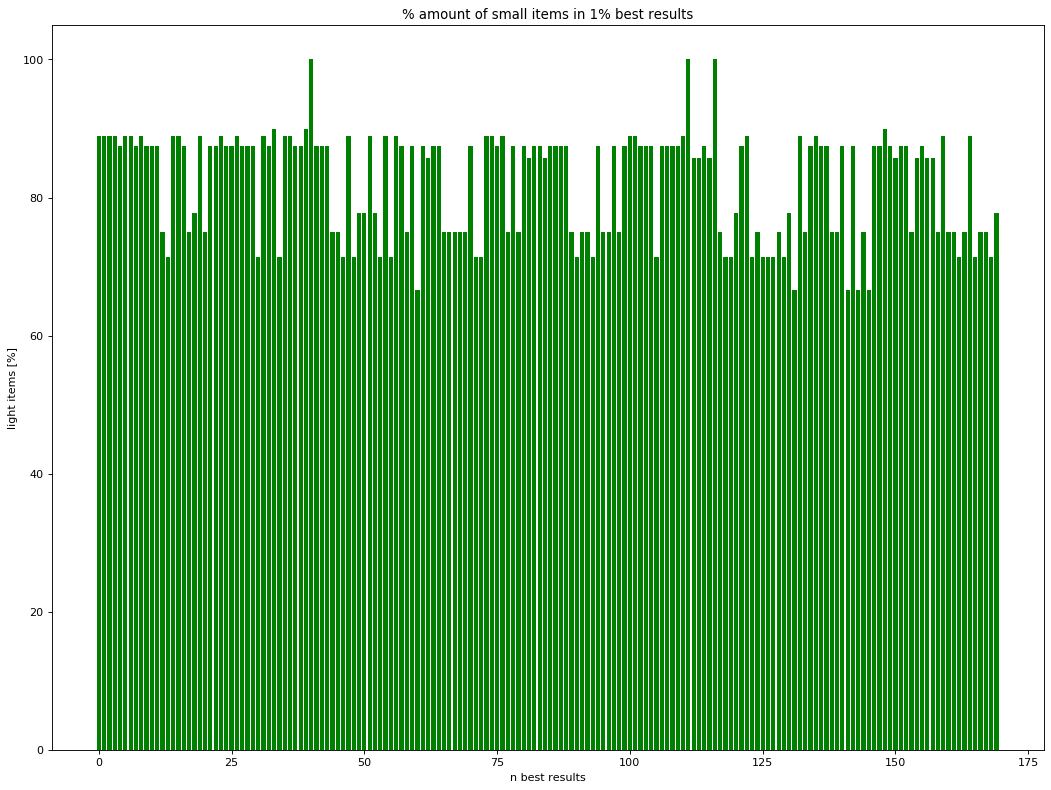

In [17]:
# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12), dpi=80) 
plt.bar(np.arange(best_1_cnt), small_items_p*100, color="g")
plt.ylabel('light items [%]')
plt.xlabel('n best results')
plt.title('% amount of small items in 1% best results')
plt.show()

### Wnioski

Z powyższych danych wynika, że lepszym rozwiazaniem jest dobieranie małych przedmiotów do plecaków. Większość (ponad 60-80% wyników) przedmiotów w najlepszych plecakach to przedmioty małe.

## Algorytm zachłanny GSA

Algorytm sortuje elementy w kolejności malejącej porównując wartości ${v}$ przedmiotu do jego wagi ${w}$.

$h = \frac{v}{w}$.


### Obliczenia

In [18]:
# Values to weight ratios with indexes for sort
VW_ratios = values / weights
indexes = np.flip(np.argsort(VW_ratios))

In [19]:
# Sort by indexes
VW_ratios = np.take_along_axis(VW_ratios, indexes, axis=0) # Value/weight ratios
VW_weights = np.take_along_axis(weights, indexes, axis=0) # Sorted weights
VW_values = np.take_along_axis(values, indexes, axis=0) # Sorted values

In [20]:
# Calculate greedy results
greedy_score = 0
greedy_weight = 0
for i in range(len(VW_ratios)):
    if(greedy_weight + VW_weights[i]) <= max_weight:
        greedy_score += VW_values[i]
        greedy_weight += VW_weights[i]

### Porównanie wyników

W porównaniu uwzględnione zostały wyniki algorytmu zachłannego oraz 10 najlepszych wyników ze wszystkich możliwych rozwiązań.

In [21]:
print("Greedy weight: ",greedy_weight)
print("Greedy score: ",greedy_score)
print("Best results (weight, value): \n",data_with_sizes[-10:,0:2])

Greedy weight:  2.7709860150069376
Greedy score:  4.871708441930054
Best results (weight, value): 
 [[2.65571179 4.69313976]
 [2.6979442  4.70059162]
 [2.88330288 4.74501949]
 [2.96497628 4.74671992]
 [2.95226796 4.76879224]
 [2.78004393 4.81811392]
 [2.87913456 4.8687458 ]
 [2.77098602 4.87170844]
 [2.99857711 4.92358817]
 [2.89531816 4.9966826 ]]


### Wnioski

Z powyższych danych wynika, że rozwiązanie zachłanne daje bardzo dobre wyniki, bliskie najlepszemu znanemu rozwiazaniu. Pondato metoda ta jest bardzo szybka, ponieważ wybiera jedynie lokalnie optymalne rozwiązania.

Otrzymany wynik z metody zachłannej jest 3 najlepszym wynikiem z całego zbioru danych, co pokazuje że nie jest to najlepsza metoda poszukiwania ekstremów globalnych. 


## Algorytm zachłanny GSA - alternatywa wartościowa

Algorytm sortuje elementy w kolejności malejącej po wartościach przedmiotów ${v}$ bez zwracania uwagi na jego wagi.

### Obliczenia

In [22]:
# Values indexes for sort
indexes = np.flip(np.argsort(values))

In [23]:
# Sort by indexes
S_weights = np.take_along_axis(weights, indexes, axis=0) # Sorted weights
S_values = np.take_along_axis(values, indexes, axis=0) # Sorted values

In [24]:
# Calculate greedy results
greedy_val_score = 0
greedy_val_weight = 0
for i in range(len(S_values)):
    if(greedy_val_weight + S_weights[i]) <= max_weight:
        greedy_val_score += S_values[i]
        greedy_val_weight += S_weights[i]

### Porównanie wyników

W porównaniu uwzględnione zostały wyniki algorytmu zachłannego oraz 10 najlepszych wyników ze wszystkich możliwych rozwiązań.

In [25]:
print("Greedy weight: ",greedy_val_weight)
print("Greedy score: ",greedy_val_score)
print("Best results (weight, value): \n",data_with_sizes[-10:,0:2])

Greedy weight:  2.940506976253459
Greedy score:  4.459977808034045
Best results (weight, value): 
 [[2.65571179 4.69313976]
 [2.6979442  4.70059162]
 [2.88330288 4.74501949]
 [2.96497628 4.74671992]
 [2.95226796 4.76879224]
 [2.78004393 4.81811392]
 [2.87913456 4.8687458 ]
 [2.77098602 4.87170844]
 [2.99857711 4.92358817]
 [2.89531816 4.9966826 ]]


### Wnioski

Inne podejście do algorytmu GSA również daje wynik zadowalający, ale zdecydowanie gorszy niż klasyczny GSA.


## Programowanie dynamiczne

Programowanie dynamiczne jest używane w problemach wymagających decyzji zależnych od siebie. Ułatwiamy decyzję przez rozbicie problemu w sekwencje łatwiejszych decyzji

In [26]:
def dp(n, max_weight, weights, values, dp_table):
    for i in range(n):
        for j in range(max_weight):
            if j < weights[i]:
                dp_table[i, j] = dp_table[i-1, j]
            else:
                dp_table[i, j] = max(dp_table[i-1, j], values[i] + dp_table[i-1, j - weights[i]])
    return dp_table

In [27]:
import math
MULTI = 1000
max_w = max_weight * MULTI
weights_m = (np.around(weights, decimals=3)*MULTI).astype(int)
dp_table = np.zeros((n_items, max_w))
%time dp_table = dp(n_items, max_w, weights_m, values, dp_table)

CPU times: user 133 ms, sys: 1.05 ms, total: 134 ms
Wall time: 132 ms


In [28]:
dp_table[-1, -1]

4.996682595542677

### Wnioski
Programowanie dynamiczne jest efektywnym rozwiązaniem, znajdującym najlepsze rozwiązanie w niewielkim czasie. Definicja problemu powoduje pewien problem - mianowicie niezbędna jest dyskretyzacja wag przedmiotów, ponieważ przy wagach będących wartościami rzeczywistymi zysk z korzystania z programowania dynamicznego jest niewielki. Wynika to z faktu, że wartości wag są unikatowe i rekurencyjne przejścia nie korzystają z uprzednio wyliczonych wartości. Odpowiednio dokładna dyskretyzacja pozwala jednak znaleźć najlepsze rozwiązanie.

## Branch & Bound

Branch and Bound to technika używana w rozwiązywaniu problemów opymalizacji. Jest ona nieco "lepsza" od metod wyczerpujących (exhaustive), ponieważ dokonuje oceny już częściowo pryzgotowanych rozwiazań, a jeżeli potencjalne pozostałe rozwiazania ne generują lepszych wyników, wtedy są pomijane.
W najgorszym przypadku B&B ma wykładniczą złożoność i wygeneruje wszystkie możliwe kombinacje liści. Wtedy drzewo będzie kompletne i będzie zawierało $2^{n-1}-1$ odgałęzień. Mimo to przeważnie i tak będzie lepszym wyborem niż sprawdzanie wszystkich możliwych rozwiązań metodą Brute Force.

B&B bazuje na drzewie przestrzni stanów, gdzie każdy kolejny poziom reprezentuje ścieżki dążące od lisci do korzenia i zaweirające rozwiazania. Przy czym korzeń (poziom 0) to punkt startowy bez żadnego rozwiązania. 

W przypadku problemu plecakowego 0-1 przy $N$ dostepnych przedmiotach $k$-ty poziom reprezentuje stan z którego wybierane jest rozwiązanie (wybrane zostały przedmioty lub nie). To daje $2^{k}$ gałęzi na $k$-tym poziomie drzewa, a liście znajdują się na poziomie $N$.


W drzewie przestrzeni stanów lewe odgałęzienie powinno oznaczać użycie kolejnego przedmiotu, a prawa gałąź jego wykluczenie.

Obliczana górna granica ($Upper Bound$) obliczana jest na zasadzie dodawania wartości obecnego podzbioru przedmiotów oraz pozostałej pojemności plecaka wymnożonej przez najlepszy kolejny przedmiot:

$Upper Bound = v + (Capacity - w)*(\frac{vi+1}{wi+1})$

Przed uruchomieniem algorytmu wszystkie przedmioty powinny być posortowane w stosunku wartość ($v$) - waga ($w$): 
$\frac{v}{w}$.

### Opis
Możliwe są 2 implementacje algorytmu B&B: 
1. wybieranie gałęzi z najmniejszą wartością graniczną. Ten sposób sprawdza mniej możliwości, a co za tym idzie zajmuje mniej czasu, ale wymaga więcej pamięci.
2. wybieranie gałezi z najmniejszą wartością graniczną z nowo utworzonych gałęzi. Ten sposób wymaga mniej pamięci ale więcej możliwych rozgałęzień co wydłuża jego czas pracy.

W poniższym algorytmie została wykorzystana metoda 1.

Algorytm na początku tworzy korzeń i z niego kolejno generuje lewe i prawe odgałęzienia sprawdzając ich granice i osiągnięte wartości.

In [29]:
# Data must be sorted in value/weights ratio way.
VW_ratios = values / weights
indexes = np.flip(np.argsort(VW_ratios))

In [30]:
VW_ratios = np.take_along_axis(VW_ratios, indexes, axis=0) # Value/weight ratios
VW_weights = np.take_along_axis(weights, indexes, axis=0) # Sorted weights
VW_values = np.take_along_axis(values, indexes, axis=0) # Sorted values

In [31]:
'''
Based on:
A. Shaheen and A. Sleit, ‘‘Comparing between different approaches to solve the 0/1 Knapsack problem’’ 
Int. J. Comput. Sci. Netw. Secur., vol. 16,no. 7, p. 1. 2016.
'''

# *** Branching with smallest node. ***

class State:
    def __init__(self, level, value, weight, bound, items):
        self.level = level
        self.value = value
        self.weight = weight
        self.bound = bound
        self.items = items
               
def upper_bound(branch, max_weight, item_count, sorted_values, sorted_weights):
    
    # *This condition is not explicitely included in default B&B*
    # If child weight exceeds maximum weight its bound should be 0 or None.
    if branch.weight > max_weight:
        return 0
    else:
        bound = branch.value 
        weight = branch.weight
        level = branch.level # Level indicates amount of items in knapsack.
        
        # Calculate upper bound based on branch parameters and left capacity
        while level < item_count and weight + sorted_weights[level] <= max_weight:
            bound += sorted_values[level]
            weight += sorted_weights[level]
            level += 1
        
        # If there is any item left (best according to value/weight ratio) add it to bound.
        if level < item_count:
            bound += (max_weight - weight) * float(sorted_values[level])/ sorted_weights[level]
            
        return bound
        
root = State(0, 0.0, 0.0, 0.0, []) # Initialize root as empty branch.
root.bound = upper_bound(root, 3, 16, VW_values, VW_weights) # Calculate root upper bound.

queue = [] # Queue to store new branches.
queue.append(root) # First item in queue is root.

max_value = root.value # First max_value is root value (0).

best_items = [0]*n_items # First best items is empty.

# Iterate till queue is not empty.
while queue:
    # Get the smallest node value (a.k.a last value).
    current_state = queue.pop()
    
    # If node bound is greater than max found value then go to the next level.
    if current_state.bound > max_value:
        level = current_state.level + 1 

    # Generate left branch.
    left = State(level, current_state.value + VW_values[current_state.level], current_state.weight + VW_weights[current_state.level], 0.0, current_state.items[:])
    # Calculate new left branch upper bound.
    left.bound = upper_bound(left, max_weight, n_items, VW_values, VW_weights)
    left.items.append(level)

    # *This condition is not explicitely included in default B&B*
    # If weight doesn't exceed maximum capacity proceed to checking vlaues.
    if left.weight <= max_weight:
        # If value is greater than max found vlaue set it as new max.
        if left.value > max_value:
            max_value = left.value
            best_items = left.items
        # Append child if its upper bound is greater than max found value.
        if left.bound > max_value:
            queue.append(left)
    
    # Generate right branch.
    right = State(level,current_state.value, current_state.weight, 0.0, current_state.items[:])
    # Calculate new right branch upper bound.
    right.bound = upper_bound(right, max_weight, n_items, VW_values, VW_weights)
    
    # Right branch is considered if left branch is not present, but in general it should not be better than left (state space tree principle).
    if right.weight <= max_weight:
        if right.value > max_value:
            max_value = right.value
            best_items = right.items
        if right.bound > max_value:
            queue.append(right)

taken_items = [0]*n_items

for item_idx in best_items:
    taken_items[item_idx-1] = 1
# print("Items taken: ",taken_items);
best_value = np.sum(VW_values[(np.where(np.array(taken_items) == 1))])
best_veight = np.sum(VW_weights[(np.where(np.array(taken_items) == 1))])
print("Best value: ",best_value)
print("Best weight: ",best_veight)

Best value:  4.996682595542677
Best weight:  2.8953181580761527


### Wnioski

Algorytm B&B jest dużo wydajniejszym algorytmem przeszukiwania niż metoda Brute Force, a dającym bardzo dobre wyniki. Uzyskany wynik jest równy najlepszemu znanemu w danym problemie. 
Algorytm ten bardzo dobrze sprawdza się dla małych rozmiarów problemów z niską korelacją waga-wartosć co zostanie przedstawione w dalszej części.

In [219]:
from random import random, randrange
import numpy as np

class Item:
    def __init__(self, name, weight, value):
        self.name = name
        self.weight = weight
        self.value = value
    def __str__(self):
        return f"{self.name} | {self.weight} kg | {self.value} zł"

class Chromosome:
    def __init__(self, size, selected = []):
        self.size = size
        self.selected = selected
        
    @staticmethod    
    def generateRandomChromosome(size):
        selected = []
        for i in range(size):
            selected.append(random() >= 0.5) 
        return Chromosome(size, selected)  
    
    def getFitnessByWeight(self, items):
        sum = 0
        for item in self.getSelectedItems(items):
            sum += item.weight
        return sum      
    
    def getFitnessByValue(self, items):
        sum = 0
        for item in self.getSelectedItems(items):
            sum += item.value
        return sum    
    
    def getSelectedItems(self, items):
        selectedItems = []
        for el in zip(self.selected, items):
            if el[0]:
               selectedItems.append(el[1])
        return selectedItems  
    
    def dominates(self, c, items):
        thisValue = self.getFitnessByValue(items)
        cValue = c.getFitnessByValue(items)
        if thisValue > cValue:
            return 1
        elif thisValue < cValue:
            return -1
        else:
            return 0
        
    def clone(self):
        return Chromosome(self.size, self.selected.copy())
    
    def __str__(self):
        return f"{self.size} {self.selected}"
    
    def isEqual(self, obj):
        return self.size == obj.size and self.selected == obj.selected
       
    def getInfo(self, items):
        return f"Weight: {self.getFitnessByWeight(items)} | Value: {self.getFitnessByValue(items)}"
    
    @staticmethod
    def removeDuplicated(chromosomes):
        newList = []
        def exists(x):
            for el in newList:
                if el.isEqual(x):
                    return True
            return False    
        for c in chromosomes:
            if not exists(c):
                newList.append(c)
        return newList
    
    @staticmethod
    def printList(chromosomes):
        for c in chromosomes:
            print(f"{c}\n")
    
class CrowdingDistanceAtom:
    def __init__(self, chromosome):
        self.chromosome = chromosome
        self.crowdingDistance = 0
    
    @staticmethod
    def mapFromChromosomes(chromosomes):
        l = []
        for c in chromosomes:
            l.append(CrowdingDistanceAtom(c))
        return l
    
    @staticmethod
    def mapToChromosomes(l):
        chromosomes = []
        for cda in l:
            chromosomes.append(cda.chromosome)
        return chromosomes   
    
class NonDominatedSortAtom:
    def __init__(self, chromosome):
        self.chromosome = chromosome
        self.dominationCount = 0
        self.dominates = []
        
    @staticmethod
    def mapFromChromosomes(chromosomes):
        l = []
        for c in chromosomes:
            l.append(NonDominatedSortAtom(c))
        return l
    
    @staticmethod
    def mapToChromosomes(l):
        chromosomes = []
        for cda in l:
            chromosomes.append(cda.chromosome)
        return chromosomes  

class GeneticOperations:
    
    def __init__(self, crossoverProbability, mutationProbability, items):
        self.crossoverProbability = crossoverProbability
        self.mutationProbability = mutationProbability
        self.items = items
    
    def crossover(self, parent1, parent2):
        if parent1.size != parent2.size:
            raise ValueError("Parents with not same size")
        selected = []
        sliceIndex = randrange(parent1.size)
        for i in range(sliceIndex):
            selected.append(parent1.selected[i])
        for i in range(sliceIndex, parent1.size):
            selected.append(parent1.selected[i])
        return Chromosome(parent1.size, selected)  
        
    def mutation(self, chromosome):
        selected = []
        for i in range(chromosome.size):
            if random() >= self.mutationProbability:
                selected.append(not chromosome.selected[i])
            else:
                selected.append(chromosome.selected[i])
        return Chromosome(chromosome.size, selected)
    
    def tournamentSelection(self, chromosomes):
        idx1 = randrange(len(chromosomes))
        idx2 = randrange(len(chromosomes))
        dominate = chromosomes[idx1].dominates(chromosomes[idx2], self.items)
        if dominate == 1:
            return chromosomes[idx1]
        elif dominate == -1:
            return chromosomes[idx2]
        elif random() < 0.5:
            return chromosomes[idx1]
        else:
            return chromosomes[idx2]
        
    def selection(self, chromosomes):
        result = []
        for i in range(len(chromosomes)):
            result.append([self.tournamentSelection(chromosomes), self.tournamentSelection(chromosomes)])
        return result

class CrowdingDistanceSort:
    def __init__(self, items):
        self.items = items
        
    def sort(self, cdaList):
        maxValue = 0
        minValue = float('inf')
        for cda in cdaList:
            fitness = cda.chromosome.getFitnessByValue(self.items)
            if fitness > maxValue:
                maxValue = fitness
                maxByValue = cda
            if fitness < minValue:
                minValue = fitness
                minByValue = cda
        maxByValue.crowdingDistance = float('inf') 
        valueDifference = maxByValue.chromosome.getFitnessByValue(self.items) - minByValue.chromosome.getFitnessByValue(self.items)
        def keyFitness(cda):
            return cda.chromosome.getFitnessByValue(self.items)
        cdaList.sort(key=keyFitness)
        sortedCDA = cdaList
        for i in range(1, len(sortedCDA) - 1):
            sortedCDA[i].crowdingDistance = (sortedCDA[i+1].chromosome.getFitnessByValue(self.items) - sortedCDA[i-1].chromosome.getFitnessByValue(self.items))/valueDifference
        def keyCrowdingDistance(cda):
            return cda.crowdingDistance
        return sortedCDA.sort(reverse=True, key=keyCrowdingDistance)    

class NonDominatedSort:
    def __init__(self, items):
        self.items = items
    
    def sort(self, ndsaList):
        frontList = []
        for i in range(len(ndsaList)-1):
            for j in range(i+1, len(ndsaList)):
                dominateResult = ndsaList[i].chromosome.dominates(ndsaList[j].chromosome, self.items)
                if dominateResult == 1:
                    ndsaList[j].dominationCount += 1
                    ndsaList[i].dominates.append(ndsaList[j])
                elif dominateResult == -1:
                    ndsaList[i].dominationCount += 1
                    ndsaList[j].dominates.append(ndsaList[i])
                else:
                    pass
        running = True
        while running:
            currentFront = []
            running = False
            dominatedList = []
            for i in range(len(ndsaList)):
                if ndsaList[i].dominationCount == 0:
                    running = True
                    ndsaList[i].dominationCount = -1
                    currentFront.append(ndsaList[i])
                    for dominated in ndsaList[i].dominates:
                        dominatedList.append(dominated)
            for dominated in dominatedList:
                dominated.dominationCount -= 1
            if len(currentFront) > 0:
                frontList.append(currentFront)
        return frontList  
    
class Nsga:
    def __init__(self, crossoverProbability, mutationProbability, items):
        self.items = items
        self.geneticOperations = GeneticOperations(crossoverProbability, mutationProbability, items)
        self.crowdingDistanceSort = CrowdingDistanceSort(items)
        self.nonDominatedSort = NonDominatedSort(items)
    
    def sortByFronts(self, chromosomes):
        fronts = self.nonDominatedSort.sort(NonDominatedSortAtom.mapFromChromosomes(chromosomes))
        def mapper(el):
            return NonDominatedSortAtom.mapToChromosomes(el)
        return list(map(mapper, fronts))
    
    def process(self, nrGeneration, populationSize):
        chromosomes = []
        for i in range(populationSize):
            chromosomes.append(Chromosome.generateRandomChromosome(len(self.items)))
        if populationSize > 2 ** len(self.items):
            populationSize = 2 ** (len(self.items) - 1) 
                       
        for currentGeneration in range(nrGeneration):
            print(f"GENERATION {currentGeneration}")
            for i in range(len(chromosomes), populationSize):
                chromosomes.append(Chromosome.generateRandomChromosome(len(self.items)))
            selectedPairParents = self.geneticOperations.selection(chromosomes)
            print(f"Selected Pair Parents size: {len(selectedPairParents)}")
            children = []     
            for selectedParents in selectedPairParents:
                children.append(self.geneticOperations.crossover(selectedParents[0], selectedParents[0]))
            def mutate(child):
                return self.geneticOperations.mutation(child)
            for c in (list(map(mutate, children))):
                print(c)
            children = Chromosome.removeDuplicated(list(map(mutate, children))) 
            print(f"Children size: {len(children)}")
            
            chromosomes = [*chromosomes, *children]
            print(f"New population size: {len(chromosomes)}")
            fronts = self.nonDominatedSort.sort(NonDominatedSortAtom.mapFromChromosomes(chromosomes))
            newPopulation = []
            currentFront = 0
            while currentFront < len(fronts) and len(newPopulation) + len(fronts[currentFront]) <= populationSize:
                newPopulation = [*newPopulation, *NonDominatedSortAtom.mapToChromosomes(fronts[currentFront])]
                currentFront += 1
            selectedAtoms = self.crowdingDistanceSort.sort(CrowdingDistanceAtom.mapFromChromosomes(NonDominatedSortAtom.mapToChromosomes(fronts[currentFront])))                       
            newPopulation = [*newPopulation, *CrowdingDistanceAtom.mapToChromosomes(selectedAtoms[:(populationSize - len(newPopulation))])]             
            chromosomes = newPopulation
            chromosomes = Chromosome.removeDuplicated(chromosomes)[:min(populationSize, len(chromosomes))]                       
        return chromosomes  
                               
# ps5 = Item("PS5", 1, 400)
# ps4 = Item("PS4", 2, 12400)
# ps3 = Item("PS3", 3, 4400)
# ps2 = Item("PS2", 4, 50)
# ps1 = Item("PS1", 5, 2)
# chromosome = Chromosome(5, [True, True, False, False, False])
# print(chromosome.getInfo([ps1,ps2,ps3,ps4,ps5]))
# print(Chromosome.generateRandomChromosome(5))
# c1 = Chromosome(1, [True])
# c2 = Chromosome(1, [True])
# c3 = Chromosome(1, [False])
# print(Chromosome.removeDuplicated([c1,c2,c3]))
                               

In [220]:
items = [
    Item("Lantisor de aur", 0.7, 500),
    Item("Unicorn", 100, 300),
    Item("Caldare", 2, 30),
    Item("Mar", 0.2, 3),
    Item("Sticla", 0.7, 4),
    Item("Telefon", 70, 500),
    Item("Banane", 0.2, 2),
    Item("Parfum", 0.4, 50),
    Item("Acumulator", 0.6, 250),
    Item("Televizor", 10, 800),
    Item("Lanterna", 0.2, 30),
    Item("Calculator", 10, 2400),
    Item("Portofel cu bani", 0.1, 300),
    Item("Elicopter RC", 0.5, 700),
    Item("MASA DE TENIS", 20, 640),
    Item("Biscuiti Oreo", 0.5, 5)
]

In [221]:
nsga = Nsga(0.9, 0.02, items)
nsga.process(10, 10)

GENERATION 0
Selected Pair Parents size: 10
16 [False, True, False, False, False, False, False, False, True, True, False, False, False, True, True, True]
16 [False, False, True, False, False, True, True, True, True, True, True, True, True, False, True, True]
16 [False, True, False, True, True, True, False, True, True, False, True, False, True, False, True, True]
16 [False, False, False, True, False, False, True, False, False, True, True, True, True, True, True, False]
16 [False, True, False, False, False, False, False, False, True, True, False, False, True, True, True, True]
16 [True, False, True, False, False, False, True, True, False, False, False, False, True, True, True, False]
16 [False, True, False, False, False, False, False, False, True, True, False, False, True, True, True, True]
16 [False, True, False, False, False, False, False, False, True, True, False, False, True, True, True, True]
16 [False, False, True, True, True, True, False, False, False, False, True, True, False, Tr

TypeError: 'NoneType' object is not subscriptable